### Import all needed package

In [99]:
import expressyeaself.construct_neural_net as construct
import expressyeaself.encode_sequences as encode
import expressyeaself.organize_data as organize
import expressyeaself.encode_sequences as encode
import os
import ast
import numpy as np
import pandas as pd
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout
from keras.utils import to_categorical
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard

ROOT_DIR = os.getcwd() + '\\'
SAVE_DIR = ROOT_DIR + 'expressyeaself\\models\\lstm\\saved_models\\'
CHECKPOINTS_DIR = ROOT_DIR + 'expressyeaself\\models\\lstm\\checkpoints\\'
CHECKPOINTS_DIR

'C:\\Users\\Lisboa\\011019\\ExpressYeaself\\expressyeaself\\models\\lstm\\checkpoints\\'

### Define the input data

#### Using the full data set

In [45]:
sample_filename = ('20190608104912821947_sequences_inserted_into_Abf1TATA_scaffold_'
                   'padded_at_back_with_exp_levels.txt.gz')
sample_filename

'20190608104912821947_sequences_inserted_into_Abf1TATA_scaffold_padded_at_back_with_exp_levels.txt.gz'

#### Using a smaller sample set

In [46]:
sample_filename = '10000_from_' + sample_filename 

#### Define the absolute path

In [47]:
sample_path = ROOT_DIR + 'example/processed_data/' + sample_filename

### Encode sequences

In [48]:
# Seems to give slightly better accuracy when expression level values aren't scaled.
scale_els = False

In [54]:
X_padded, y_scaled, abs_max_el = encode.encode_sequences_with_method(sample_path, method='One-Hot', scale_els=scale_els, model_type='LSTM')
num_seqs, max_sequence_len = organize.get_num_and_len_of_seqs_from_file(sample_path)

TypeError: 'float' object cannot be interpreted as an integer

In [55]:
X_padded, y_scaled, abs_max_el = encode.encode_sequences_with_method(sample_path, method='One-Hot', scale_els=scale_els)
num_seqs, max_sequence_len = organize.get_num_and_len_of_seqs_from_file(sample_path)

### Reshape encoded sequences

In [85]:
X_padded = X_padded.reshape(-1)
X_padded = X_padded.reshape(int(num_seqs), 1, 5 * int(max_sequence_len))

### Reshape expression levels

In [87]:
y_scaled = y_scaled.reshape(len(y_scaled), 1, 1)

### Perform a train-test split

In [63]:
test_size = 0.25

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_scaled, test_size=test_size)

### Build the model architecture

In [96]:
# Define the model parameters
batch_size = int(len(y_scaled) * 0.01)  # no bigger than 1 % of data
epochs = 2
dropout = 0.5
learning_rate = 0.01

# Define the checkpointer to allow saving of models
model_type = 'lstm_sequential_onehot'
save_path = SAVE_DIR + model_type + '.hdf5'
checkpointer = ModelCheckpoint(monitor='val_acc', 
                               filepath=save_path, 
                               verbose=1, 
                               save_best_only=True)

# Define the model
model = Sequential()

# Build up the layers

model.add(Dense(1024, kernel_initializer='uniform', input_shape=(1,5*int(max_sequence_len),)))
model.add(Activation('softmax'))
model.add(Dropout(dropout))
model.add(Dense(512, kernel_initializer='uniform', input_shape=(1,1024,)))
model.add(Activation('softmax'))
model.add(Dropout(dropout))
model.add(Dense(256, kernel_initializer='uniform', input_shape=(1,512,)))
model.add(Activation('softmax'))
model.add(Dropout(dropout))
model.add(Dense(128, kernel_initializer='uniform', input_shape=(1,256,)))
model.add(Activation('softmax'))
model.add(Dropout(dropout))
model.add(Dense(64, kernel_initializer='uniform', input_shape=(1,128,)))
model.add(Activation('softmax'))
model.add(Dropout(dropout))
model.add(Dense(32, kernel_initializer='uniform', input_shape=(1,64,)))
model.add(Activation('softmax'))
model.add(Dropout(dropout))
model.add(Dense(16, kernel_initializer='uniform', input_shape=(1,32,)))
model.add(Activation('softmax'))
model.add(Dropout(dropout))
model.add(Dense(8, kernel_initializer='uniform', input_shape=(1,16,)))
model.add(Activation('softmax'))

model.add(LSTM(units=1, input_shape = (1,8), return_sequences=True))
sgd = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])

# Print model summary
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 1, 1024)           1496064   
_________________________________________________________________
activation_65 (Activation)   (None, 1, 1024)           0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 1, 1024)           0         
_________________________________________________________________
dense_66 (Dense)             (None, 1, 512)            524800    
_________________________________________________________________
activation_66 (Activation)   (None, 1, 512)            0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 1, 512)            0         
_________________________________________________________________
dense_67 (Dense)             (None, 1, 256)            131328    
__________

### Fit and Evaluate the model

Train on 7500 samples, validate on 2500 samples
Epoch 1/2
7500/7500 [==============================] - 4s 596us/step - loss: 68.4757 - acc: 0.0156 - val_loss: 65.6233 - val_acc: 0.0120

Epoch 00001: val_acc did not improve from 0.01200
Epoch 2/2
7500/7500 [==============================] - 4s 593us/step - loss: 67.6388 - acc: 0.0156 - val_loss: 64.7958 - val_acc: 0.0120

Epoch 00002: val_acc did not improve from 0.01200
acc: 1.20%


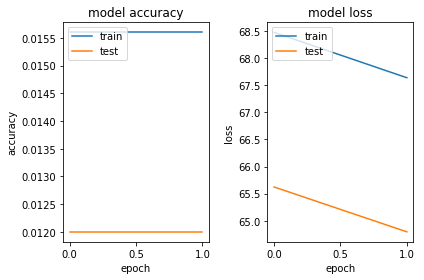

In [100]:
# Fit
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,verbose=1,
                    validation_data=(X_test, y_test), callbacks=[checkpointer])


# Evaluate
score = max(history.history['val_acc'])
print("%s: %.2f%%" % (model.metrics_names[1], score*100))
plt = construct.plot_results(history.history)
plt.show()